<a href="https://colab.research.google.com/github/samuraiguilherme/surfboards-training/blob/main/surfboard_image_classif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [3]:
from PIL import Image
import math
from keras import layers, ops
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.metrics import (
    BinaryAccuracy,
    FalsePositives,
    FalseNegatives,
    TruePositives,
    TrueNegatives,
    Precision,
    Recall,
    AUC,
)
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
DATASET_DIR = 'surfboards-images-raw'
IMAGE_SIZE = 224
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
NUM_EPOCHS = 50
BATCH_SIZE = 4
PROJECTION_DIM = 64
TRANSFORMER_LAYERS = 8
NUM_HEADS = 4
TRANSFORMER_UNITS = [PROJECTION_DIM*2, PROJECTION_DIM]
MLP_HEAD_UNITS = [2048, 1024]

In [5]:
train_ds = keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    labels='inferred',
    # image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=0,
    color_mode='rgb',
    validation_split=0.2,
    subset='training',
    verbose=1
).prefetch(tf.data.AUTOTUNE)

val_ds = keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    labels='inferred',
    # image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=2,
    color_mode='rgb',
    validation_split=0.2,
    subset='validation',
).prefetch(tf.data.AUTOTUNE)

Found 72 files belonging to 2 classes.
Using 58 files for training.
Found 72 files belonging to 2 classes.
Using 14 files for validation.


In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Cropping2D(cropping=((170, 0), (0, 0))),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip('horizontal'),
    ],
    name='data_augmentation'
)

# data_augmentation.layers[0].adapt(train_ds.map(lambda x,y : x))

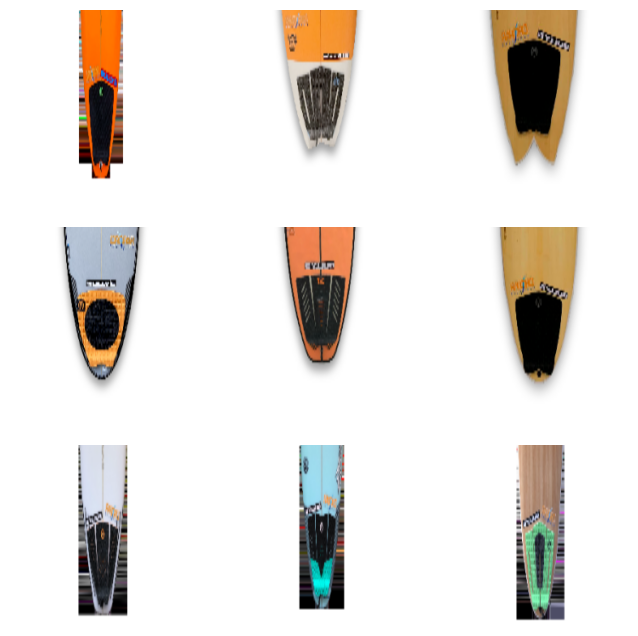

In [106]:
GRID_SIZE = 3
plt.figure(figsize=(8, 8))

for image, label in train_ds.take(1):
  aug = data_augmentation(image)
  # aug = layers.Conv2D(1, 24)(aug)
  # aug = layers.MaxPool2D(2)(aug)
  for i in range(GRID_SIZE * GRID_SIZE):
    plt.subplot(GRID_SIZE, GRID_SIZE, i + 1)
    plt.imshow(aug[i].numpy().astype("uint8"))
    plt.axis('off')  # Hide axes

In [7]:
backbone = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=INPUT_SHAPE,
    pooling='avg',
    classes=2
)
backbone.trainable = False

def create_classifier():
    inputs = layers.Input(shape=(256, 256, 3))
    augmented = data_augmentation(inputs)

    x = preprocess_input(augmented)
    x = backbone(x, training=False)

    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return keras.Model(inputs, outputs, name='surfboard-classifier')

model = create_classifier()
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-4),
    metrics=[
        TruePositives(name='tp'),
        FalsePositives(name='fp'),
        TrueNegatives(name='tn'),
        FalseNegatives(name='fn'),
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ],
    run_eagerly=False
)
model.summary()

Model: "surfboard-classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation         │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ data_augmentation[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ data_augmentation[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ data_augmentation[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 512)            │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512)            │          2,048 │ vgg16[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 512)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         65,664 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64)             │            256 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ batch_normalization_1… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,790,977 (56.42 MB)

 Trainable params: 75,137 (293.50 KB)

 Non-trainable params: 14,715,840 (56.14 MB)

In [8]:

checkpoint_filepath = 'checkpoint.weights.h5'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
)
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
)
early_stop_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    restore_best_weights=True
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
    callbacks=[checkpoint_cb, reduce_lr_cb, early_stop_cb],
    verbose=1
)
model.load_weights(checkpoint_filepath)
result = model.evaluate(val_ds, verbose=1)
print('result: ',result)
# print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

model.save('surfboard-classifier.keras')


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 52s 25s/step - accuracy: 0.4124 - auc: 0.3424 - fn: 12.0000 - fp: 16.6667 - loss: 1.0282 - precision: 0.4056 - recall: 0.4889 - tn: 9.0000 - tp: 11.6667 - val_accuracy: 0.5000 - val_auc: 0.7551 - val_fn: 7.0000 - val_fp: 0.0000e+00 - val_loss: 1.2550 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 7.0000 - val_tp: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.4896 - auc: 0.5177 - fn: 11.6667 - fp: 13.3333 - loss: 0.7836 - precision: 0.4700 - recall: 0.5111 - tn: 12.3333 - tp: 12.0000 - val_accuracy: 0.5000 - val_auc: 0.8163 - val_fn: 7.0000 - val_fp: 0.0000e+00 - val_loss: 1.1283 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 7.0000 - val_tp: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.5668 - auc: 0.5704 - fn: 10.6667 - fp: 10.6667 - loss: 0.7593 - precision: 0.5761 - recall: 0.5661 - tn: 14.0000 - tp: 14.0000 -